In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Part 1: From linear to logistic regression...

We use again the `chimera_data.csv` from earlier lectures. We will try to predict employee exit, using only some of the key columns in the data set:

In [2]:
df = pd.read_csv("chimera_data.csv")
df = df[["boss_survey","salary","exit"]]

In [3]:
df.head()

,boss_survey,salary,exit
0,0.655444,53.894035,0
1,0.533455,35.606964,0
2,0.486568,27.400360,0
3,0.477364,36.138199,0
4,0.603230,42.778580,1


In [4]:
np.mean(df.exit)

0.13550628722700198

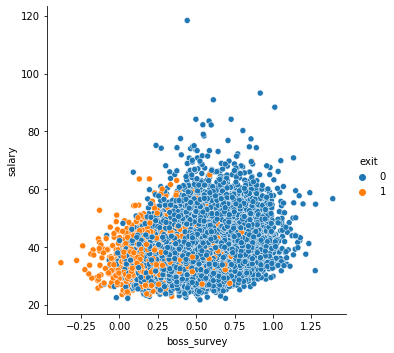

In [5]:
sns.relplot(x="boss_survey",y="salary",hue="exit",data=df)
plt.show()

We simplify this further, by looking only at the `boss_survey` result as an independent variable:

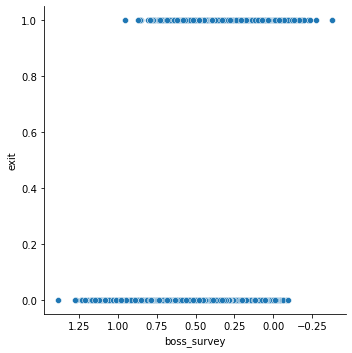

In [6]:
sns.relplot(x="boss_survey",y="exit",data=df)
plt.gca().invert_xaxis()
plt.show()

We can, of course, run a linear regression on this data. We will use scikit here.

In [8]:
X=df[["boss_survey"]]
Y=df[["exit"]]

lm = LinearRegression().fit(X, Y) # Fit a linear regression with vector Y as dependent and matrix X as independent

print("Intercept = ",lm.intercept_) # Print the resultant model intercept 
print("Model coefficients = ", lm.coef_) # Print the resultant model coefficients (in order of variables in X)
print("R^2 =",lm.score(X,Y)) # Print the resultant model R-squared

Intercept =  [0.47652802]
Model coefficients =  [[-0.68204346]]
R^2 = 0.15883230859845232


We plot the result using scikit's `predict` function together with `matplotlib`:

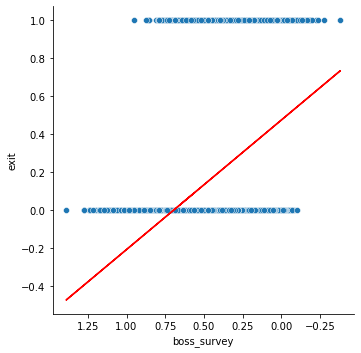

In [10]:
Y_pred=lm.predict(X)
sns.relplot(x="boss_survey",y="exit",data=df)
plt.plot(X,Y_pred,color="red")
plt.gca().invert_xaxis()
plt.show()

The predictions are rather problematic. Why?

## Univariate logistic regression

We use scikit-learn here to do Logistic Regression. The code looks very similar to Linear Regression.

In [11]:
X=df[["boss_survey"]]
y=df["exit"]

logm = LogisticRegression().fit(X, y) # Fit a logistic regression with vector Y as dependent and matrix X as independent

print("Intercept = ",logm.intercept_) # Print the resultant model intercept 
print("Model coefficients = ", logm.coef_) # Print the resultant model coefficients (in order of variables in X)
print("R^2 =",logm.score(X,y)) # Print the resultant model R-squared

Intercept =  [1.10815589]
Model coefficients =  [[-7.15867705]]
R^2 = 0.8757445400397088


To get the predictions, we proceed as with linear regression:

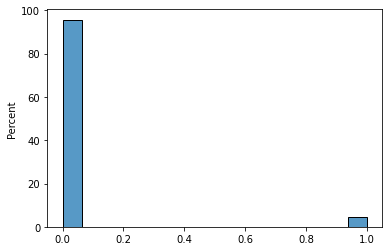

In [12]:
labels_pred=logm.predict(X)
sns.histplot(labels_pred,stat='percent')
plt.show()

The prediction above is based on an arbitrary threshold around the probability of leaving. We can, instead, look at that probability. For this, we use `.predict_proba(X)`. Be aware that this returns both sides (the probability of not leaving and the probability of leaving) for each employee:

In [13]:
probs_pred=logm.predict_proba(X)
print(probs_pred)

[[0.97298449 0.02701551]
 [0.93765382 0.06234618]
 [0.91490288 0.08509712]
 ...
 [0.77661197 0.22338803]
 [0.98931691 0.01068309]
 [0.94899972 0.05100028]]


We can now plot the probability of leaving against the actual choices:

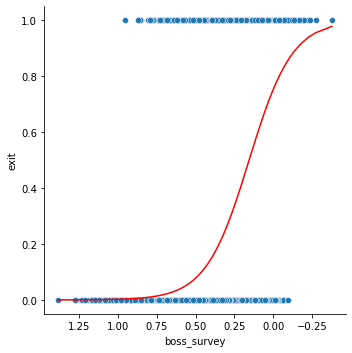

In [15]:
X_plot, y_plot = zip(*sorted(zip(X.values, probs_pred[:,1])))
sns.relplot(x="boss_survey",y="exit",data=df)
plt.plot(X_plot, y_plot,color="red")
plt.gca().invert_xaxis()
plt.show()

## Multivariate logistic regression

Of course, we can use more than one explanatory variable:

In [16]:
y=df["exit"] #creating the dependent variable
X=df.drop(columns=["exit"]) #dropping the dependent variable to get a matrix of independent features

Let's run the logit model again:

In [17]:
logm = LogisticRegression().fit(X, y) # Fit a logistic regression with vector Y as dependent and matrix X as independent

print("Intercept = ",logm.intercept_) # Print the resultant model intercept 
print("Model coefficients = ", logm.coef_) # Print the resultant model coefficients (in order of variables in X)
print("R^2 =",logm.score(X,y)) # Print the resultant model R-squared

Intercept =  [1.00133552]
Model coefficients =  [[-7.18387772e+00  3.06362807e-03]]
R^2 = 0.8757996911537613


# Part 2: Setting the threshold

So far, we have just predicted the model on the same data as the data on which we trained it. Of course, this is not ideal. Here, we will be using a train and a validation dataset to find the best threshold, then use this threshold to check how good our model is on the test data:

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [19]:
y = df["exit"] #creating the dependent variable
X = df.drop(columns=["exit"]) #dropping the dependent variable to get a matrix of independent features

We split the dataset into train (50%), test (25%) and validation (25%).

In [20]:
trainX, otherX, trainY, otherY = train_test_split(X, Y, test_size=0.5,random_state = 726)

In [21]:
trainX

,boss_survey,salary
12044,0.425758,42.025589
9939,0.704601,43.318298
14732,0.671257,29.091583
14339,0.700700,44.175140
17041,0.686749,35.097565
...,...,...
12509,0.576801,39.721275
8371,0.722644,41.757744
16107,0.408002,52.427902
2510,0.691043,39.169518


In [22]:
trainY

,exit
12044,0
9939,0
14732,0
14339,0
17041,0
...,...
12509,0
8371,0
16107,0
2510,0


In [23]:
otherX

,boss_survey,salary
7817,0.582968,41.001167
15016,0.626672,33.022781
4580,0.471439,39.959793
3279,0.332104,28.540909
10302,0.455162,30.829208
...,...,...
13260,0.460608,34.721695
7610,0.450173,36.341995
6080,0.607913,31.519516
3313,0.620558,41.208809


In [24]:
otherY

,exit
7817,0
15016,0
4580,0
3279,0
10302,0
...,...
13260,0
7610,0
6080,0
3313,0


In [25]:
testX, validationX, testY, validationY = train_test_split(otherX, otherY, test_size=0.5,random_state = 1592)

In [27]:
print(X.shape)
print(Y.shape)
print(trainX.shape)
print(trainY.shape)
print(validationX.shape)
print(validationY.shape)
print(testX.shape)
print(testY.shape)

(18132, 2)
(18132, 1)
(9066, 2)
(9066, 1)
(4533, 2)
(4533, 1)
(4533, 2)
(4533, 1)


We fit the model to the dataset using scikit learn, **only on the training data**:

Note: `.values.ravel()` will turn the dataframe column-vector `trainY` into a 1-dimensional array and avoid warnings. It's not strictly necessary with the current version of Python, but it may avoid issues in future versions.

In [28]:
logm = LogisticRegression()
logm.fit(trainX, trainY.values.ravel()) # Fit a logistic regression with vector Y as dependent and matrix X as independent
print(logm.intercept_)
print(logm.coef_)

[1.04851549]
[[-6.98012566e+00  5.63882206e-04]]


As before, we get prediction probabilities (this time on the validation dataset). However, we only care about one side (the probability of having "1", that is, of leaving).

In [29]:
logm.predict_proba(validationX)

array([[0.99193174, 0.00806826],
       [0.69044713, 0.30955287],
       [0.53715586, 0.46284414],
       ...,
       [0.87480019, 0.12519981],
       [0.69563881, 0.30436119],
       [0.98414677, 0.01585323]])

In [30]:
Y_probs=logm.predict_proba(validationX)[:,1]

We can now display the ROC curve. For this, we use `roc_curve` from `sklearn.metrics` (the documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)). The function returns three lists, all indexed in the same way. In the first list, we can find the false positive rates, in the second list we find the true positive rates, and in the third list, we find the corresponding threshold.

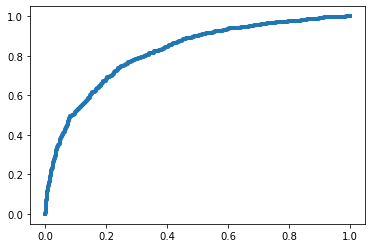

In [31]:
from matplotlib import pyplot
fpr, tpr, thresholds = metrics.roc_curve(validationY,Y_probs)
pyplot.plot(fpr, tpr, linewidth=4)
plt.show()

We can stake out the different points on the graph manually:

In [32]:
print("The threshold at index 10 is " + str(thresholds[10]))
print("The false positive rate at this threshold is " + str(fpr[10]))
print("The true positive rate at this threshold is " + str(tpr[10])) 

The threshold at index 10 is 0.6988919318451284
The false positive rate at this threshold is 0.0012745347947998981
The true positive rate at this threshold is 0.04426229508196721


In [33]:
print("The threshold at index 200 is " + str(thresholds[200]))
print("The false positive rate at this threshold is " + str(fpr[200]))
print("The true positive rate at this threshold is " + str(tpr[200])) 

The threshold at index 200 is 0.3565960505074471
The false positive rate at this threshold is 0.04792250828447617
The true positive rate at this threshold is 0.36721311475409835


In [34]:
print("The threshold at index 800 is " + str(thresholds[800]))
print("The false positive rate at this threshold is " + str(fpr[800]))
print("The true positive rate at this threshold is " + str(tpr[800])) 

The threshold at index 800 is 0.03328311932761488
The false positive rate at this threshold is 0.7259750191180219
The true positive rate at this threshold is 0.9622950819672131


The AUC summarizes the quality of our model by measuring (roughly) how close we can get to a perfect model. In particular, it gives an idea of how far to the top-left we can get in our ROC:

In [35]:
roc_auc_score(validationY,Y_probs)

0.8185651663372376

Now, we need to choose a threshold (note, the default chosen in making predictions by sklean is 0.5). A natural threshold to choose is 0.1355 (why?)

**because the average probability of leaving is 0.1355, good starting point for the threshold if dataset is skewed.**

In [36]:
chosen_threshold = np.min(thresholds[thresholds > 0.1355])
print(chosen_threshold)
threshold_idx = np.where(thresholds == chosen_threshold)[0][0]
print(threshold_idx)

0.1358205325954384
584


The FPR and TPR at this threshold are:

In [37]:
print("At threshold  " + str(thresholds[threshold_idx]))
print("the false positive rate is " + str(fpr[threshold_idx]))
print("and the true positive rate is " + str(tpr[threshold_idx]))

At threshold  0.1358205325954384
the false positive rate is 0.2801427478970176
and the true positive rate is 0.7704918032786885


With a choice of thresholds, we can now make predictions (on the validation set) and display the confusion matrix:

In [38]:
Y_pred = np.where(Y_probs > chosen_threshold, 1, 0)
Y_pred

array([0, 1, 1, ..., 0, 1, 0])

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validationY,Y_pred)
print(cm)

[[2824 1099]
 [ 141  469]]


In [40]:
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

We can now verify the false and true positive rates:

In [41]:
1-TN/(FP+TN)

0.28014274789701754

In [42]:
TP/(TP+FN)

0.7688524590163934

We will discuss other methods for choosing thresholds in the tutorial.

# Part 3: Retraining the final model with training+validation, then testing it (time permitting)

In [43]:
trainX_final=pd.concat([trainX, validationX])
trainY_final=pd.concat([trainY, validationY])

We now train our model on `trainX_final` and `trainY_final` with treshold `0.1355` using scikit learn

In [44]:
logm = LogisticRegression().fit(trainX_final, trainY_final.values.ravel())

In [49]:
Y_test_probs=logm.predict_proba(validationX)[:,1]
threshold = 0.1355
Y_test_pred=np.where(Y_test_probs > threshold, 1, 0) #predict the classes for test data based on the threshold found via the validation data

In [50]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(testY,Y_test_pred))

[[2594 1347]
 [ 385  207]]


# Part 4: Using CART decision trees for classification (time permitting - we will look at this in the tutorial)

There are other ways to perform classification, such as decision trees. While we won't talk a lot about the underlying theory (you will cover this in your machine learning class), they can be quite the powerful tool for classification (and, actually, also for prediction).

Compared to logistic regression, decision trees don't require any structural assumptions (remember, under logistic regression, we assume an exponential of a linear function). However, greater flexibility comes at a cost: there are a bunch more options to choose from when using those. For our purposes, we will concentrate on the `max_leaf_nodes`, which is usually the option with the biggest impact.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import graphviz as gp
from sklearn.tree import export_graphviz

The usage in Python is quite intuitive - we only need to replace `LogisticRegression` with `DecisionTreeClassifier` (and define the `max_leaf_nodes`):

In [ ]:
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 4)
classifier_DT.fit(trainX, trainY.values.ravel())

One of the major advantages of decision trees is that they are quite intuitive. Let's take a look:

In [ ]:
dot_data = export_graphviz(classifier_DT, feature_names = trainX.columns, filled = True, rounded = True, class_names=["No exit","Exit"])
graph = gp.Source(dot_data)
graph

The usage is exactly as with the logistic regression. For example, we can get the probability of exit on the validation set:

In [ ]:
Y_probs=classifier_DT.predict_proba(validationX)[:,1]

We can also print the ROC curve:

In [ ]:
from matplotlib import pyplot
fpr, tpr, thresholds = metrics.roc_curve(validationY,Y_probs)
pyplot.plot(fpr, tpr, linewidth=4)
plt.show()

Finally, we can find the AUC to measure the quality of the model. We could, for example, vary `max_leaf_nodes` to get a higher AUC:

In [ ]:
roc_auc_score(validationY,Y_probs)

There are even more advanced classifiers, such as
```
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
```
They bring in better predictive power at the cost of higher parameter-setting complexity. But the usage is pretty much the same as for logistic regression and CART, so feel free to try it out.

# Exercise: FP and FN

Give everyday life examples where it would be preferable to (i) have false positives rather than false negatives, or (ii) have false negatives rather than false positives.
